# Covid-19 Predictions

Based on the notebook:  
https://www.kaggle.com/therealcyberlord/coronavirus-covid-19-visualization-prediction  
  
___
  
It's important to note that predictions should never replace medical and technical advise, this is for illustration and research only.  
  
Most of the work here was build by someone else, I'm using their work as base for testing, modifying, and visualizing the predictions.  
  
It's also importand to add that the current available data is considered by many (health care professionals, media, and organizations) extremelly incomplete. The reasons reported for this issue are the diferent ways countries are reporting, and testing the cases.

In [1]:
# Based on the work of https://www.kaggle.com/therealcyberlord/coronavirus-covid-19-visualization-prediction

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
from PIL import Image, ImageDraw

plt.style.use('seaborn-colorblind')
%matplotlib inline 

## Load and Prepare Data

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-14-2020.csv')

In [3]:
cols = confirmed_df.keys()
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())

In [4]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [5]:
# Days since 1,000 cases
days_since_1k = [int(i) for i in np.zeros(3)]
for i in range(len(dates[3:])):
    days_since_1k.append(i)

days_since_1k = np.array(days_since_1k).reshape(-1, 1)

# Days since 10,000 cases
days_since_10k = [int(i) for i in np.zeros(10)]
for i in range(len(dates[10:])):
    days_since_10k.append(i)

days_since_10k = np.array(days_since_10k).reshape(-1, 1)

# Days since 100,000 cases
days_since_100k = [int(i) for i in np.zeros(44)]
for i in range(len(dates[44:])):
    days_since_100k.append(i)

days_since_100k = np.array(days_since_100k).reshape(-1, 1)

# Days since 100,000 cases
days_since_1m = [int(i) for i in np.zeros(71)]
for i in range(len(dates[71:])):
    days_since_1m.append(i)

days_since_1m = np.array(days_since_1m).reshape(-1, 1)

X =  pd.DataFrame(days_since_1_22)
X['1k'] = days_since_1k
X['10k'] = days_since_10k
X['100k'] = days_since_100k
X['1m'] = days_since_1m

### Prepare dates

In [6]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [7]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

# Days since 1,000 cases
future_1k = [int(i) for i in np.zeros(3)]
for i in range(len(dates[3:])+days_in_future):
    future_1k.append(i)

future_1k = np.array(future_1k).reshape(-1, 1)

# Days since 10,000 cases
future_10k = [int(i) for i in np.zeros(10)]
for i in range(len(dates[10:])+days_in_future):
    future_10k.append(i)

future_10k = np.array(future_10k).reshape(-1, 1)

# Days since 100,000 cases
future_100k = [int(i) for i in np.zeros(44)]
for i in range(len(dates[44:])+days_in_future):
    future_100k.append(i)

future_100k = np.array(future_100k).reshape(-1, 1)

# Days since 1,000,000 cases
future_1m = [int(i) for i in np.zeros(71)]
for i in range(len(dates[71:])+days_in_future):
    future_1m.append(i)

future_1m = np.array(future_1m).reshape(-1, 1)

future_forcast =  pd.DataFrame(future_forcast)
future_forcast['1k'] = future_1k
future_forcast['10k'] = future_10k
future_forcast['100k'] = future_100k
future_forcast['1m'] = future_1m

### Prepare train and test data

In [8]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(X, world_cases, test_size=0.02, shuffle=False) 

# Regressions

## SVM - Support Vector Machine Regressor

C:\Users\thiag\.conda\envs\Training\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 60052.55998707004
MSE: 3614093588.7749715


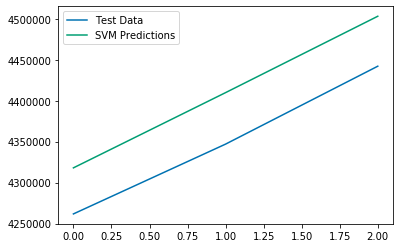

In [9]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.023, epsilon=2, degree=4, C=1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

## Polynomial Regression

In [10]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

print(linear_model.coef_)

MAE: 10362.132395426432
MSE: 124966885.23027496
[[ 5.55096448e+02  4.26567231e+01 -4.18572473e+00 -1.58635983e-03
   9.53230113e-04  4.46658180e-04  3.47759304e+01 -7.12784829e+00
  -1.07302627e-02 -1.58890883e-06 -7.30768057e-07  5.42824870e+00
  -3.33586398e-03 -5.74604588e-07  1.08941030e-06  1.38962973e-02
   7.33480013e-08 -1.05527469e-07  5.06368491e-06  3.06523004e-07
   6.37956763e-07  2.04167542e+01 -9.49110032e+00 -3.76256928e-02
  -1.03180067e-05 -3.19154644e-06  1.18924394e+01 -5.47714535e-03
  -6.12350393e-06 -2.49962580e-06  6.95364342e-02  3.65785560e-06
  -8.83741347e-07  5.11541235e-05  6.90866583e-06  1.31131977e-05
  -4.39266950e+00  4.52010964e-03 -3.25971329e-06 -1.90883359e-06
   2.78470190e-02  3.43782219e-06 -5.79092267e-07  3.59275170e-05
   5.93988715e-06  1.11863798e-05 -6.94283403e-02  2.92514939e-06
   1.75733674e-07  3.85531629e-07  3.80868049e-06  6.71554678e-06
  -1.72248187e-04 -6.72100310e-06 -1.50736761e-05 -3.23162222e-05
   1.89405197e+00 -8.2311401

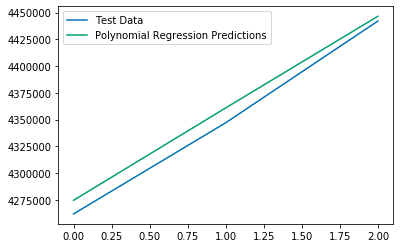

In [11]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

## Bayesian Ridge Polynomial Regression

In [12]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    1.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished
C:\Users\thiag\.conda\envs\Training\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=False, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'tol': [0.0001, 0.001, 0.01], 'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001], 'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001], 'lambda_1': [1e-07, 1e-06, 1e-05, 0.0001], 'lambda_2': [1e-07, 1e-06, 1e-05, 0.0001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=1)

In [13]:
bayesian_search.best_params_

{'tol': 0.01,
 'lambda_2': 1e-07,
 'lambda_1': 1e-06,
 'alpha_2': 1e-07,
 'alpha_1': 0.0001}

In [14]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 15774.707060893377
MSE: 257125253.95555866


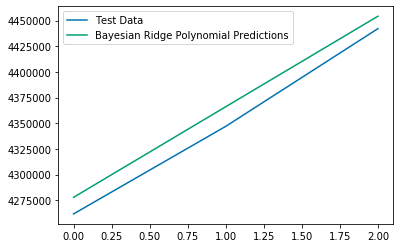

In [15]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

# Visualizations

SVM future predictions:


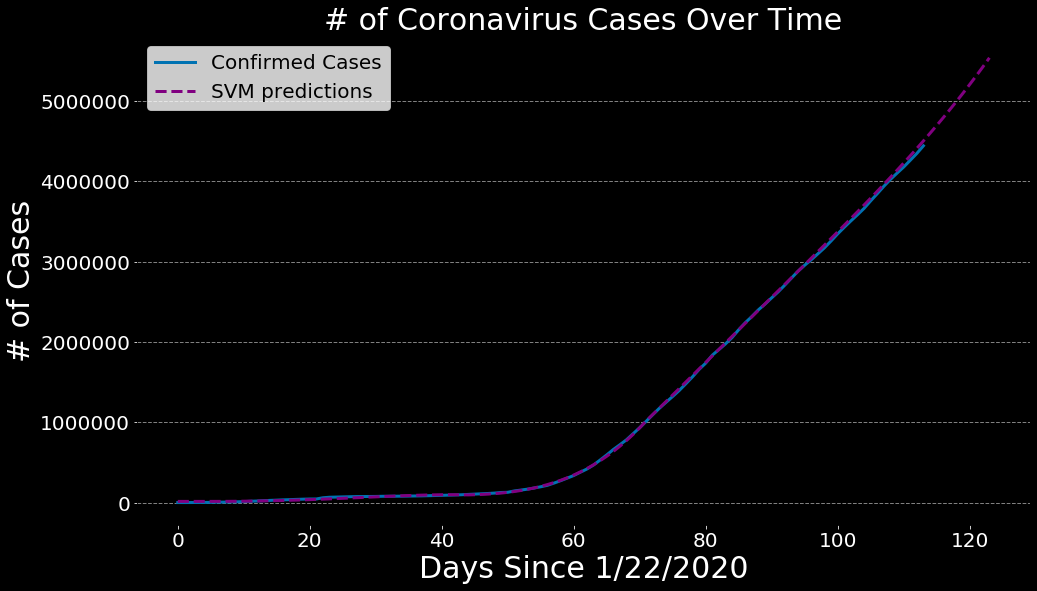

In [16]:
fig, ax = plt.subplots(1, figsize=(16, 9), facecolor='black')
plt.plot(adjusted_dates, world_cases, linewidth=3)
plt.plot(future_forcast[0], svm_pred, linestyle='dashed', color='purple', linewidth=3)
plt.title('# of Coronavirus Cases Over Time', size=30, color = 'white')
plt.xlabel('Days Since 1/22/2020', size=30, color = 'white')
plt.ylabel('# of Cases', size=30, color = 'white')
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20, color = 'white')
plt.yticks(size=20, color = 'white')

# grid
ax.grid(color='grey', linestyle='dashed', linewidth=1, axis = 'y')
ax.set_axisbelow(True)

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
#Colors
ax.set_facecolor('xkcd:black')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')

plt.savefig('img/svm_prediction.png', facecolor='black', edgecolor='none')

# Future predictions using SVM 
print('SVM future predictions:')
#set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

img = Image.new('RGB', (150, 100), color = (0, 0, 0))
d = ImageDraw.Draw(img)

pred = set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))
df_pred = pd.DataFrame(pred)
df_pred.sort_values(0, inplace=True)
df_pred.reset_index(inplace=True)

for index, val in df_pred.iterrows():
    txt = val[0] + ' - {:,}'.format( int(val[1]) )  
    d.text((10,index*10), txt, fill=(255,87,51))

img.save('img/svm_prediction_txt.png')

Polynomial regression future predictions:


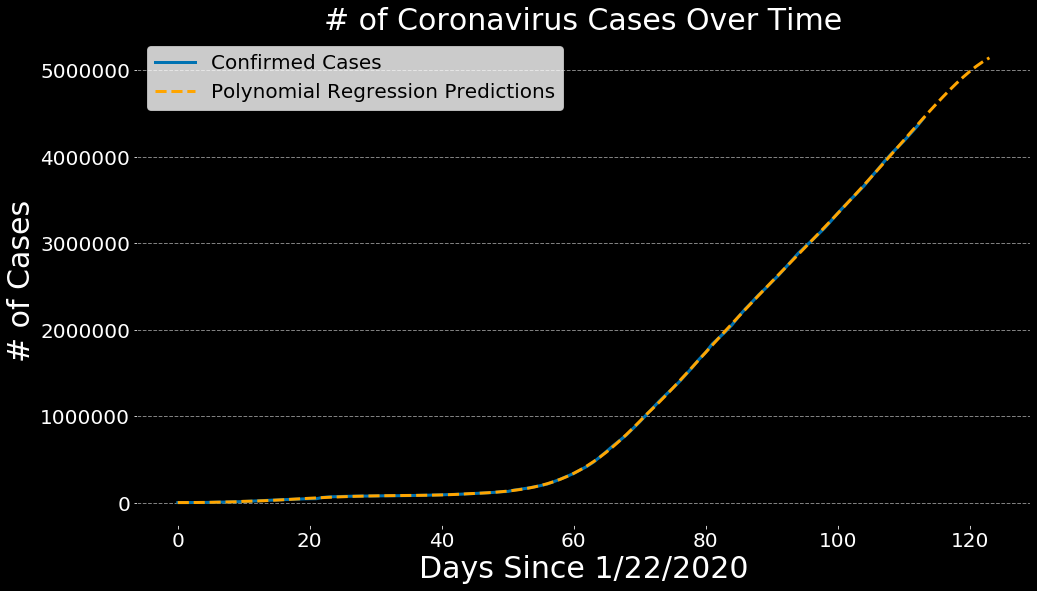

In [17]:
fig, ax = plt.subplots(1, figsize=(16, 9), facecolor='black')
plt.plot(adjusted_dates, world_cases, linewidth=3)
plt.plot(future_forcast[0], linear_pred, linestyle='dashed', color='orange', linewidth=3)
plt.title('# of Coronavirus Cases Over Time', size=30, color = 'white')
plt.xlabel('Days Since 1/22/2020', size=30, color = 'white')
plt.ylabel('# of Cases', size=30, color = 'white')
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20, color = 'white')
plt.yticks(size=20, color = 'white')

# grid
ax.grid(color='grey', linestyle='dashed', linewidth=1, axis = 'y')
ax.set_axisbelow(True)

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
#Colors
ax.set_facecolor('xkcd:black')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')

plt.savefig('img/polynomial_regression.png', facecolor='black', edgecolor='none')

linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
#set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))

img = Image.new('RGB', (150, 100), color = (0, 0, 0))
d = ImageDraw.Draw(img)

pred = set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))
df_pred = pd.DataFrame(pred)
df_pred.sort_values(0, inplace=True)
df_pred.reset_index(inplace=True)

for index, val in df_pred.iterrows():
    txt = val[0] + ' - {:,}'.format( int(val[1]) )  
    d.text((10,index*10), txt, fill=(255,87,51))

img.save('img/polynomial_regression_txt.png')
#img.show()

Ridge regression future predictions:


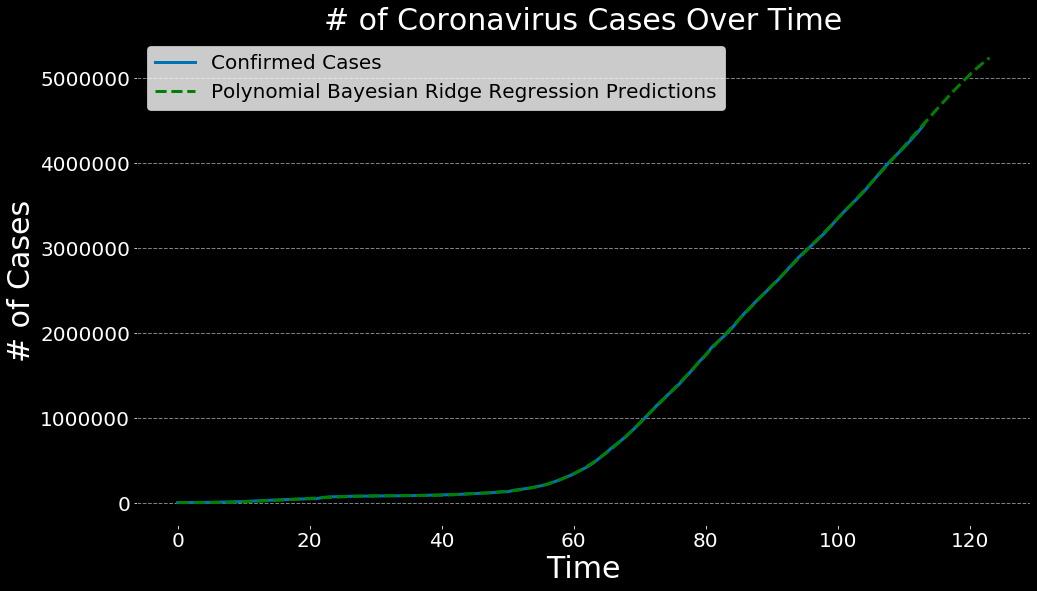

In [18]:
fig, ax = plt.subplots(1, figsize=(16, 9), facecolor='black')
plt.plot(adjusted_dates, world_cases, linewidth=3)
plt.plot(future_forcast[0], bayesian_pred, linestyle='dashed', color='green', linewidth=3)
plt.title('# of Coronavirus Cases Over Time', size=30, color = 'white')
plt.xlabel('Time', size=30, color = 'white')
plt.ylabel('# of Cases', size=30, color = 'white')
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20, color = 'white')
plt.yticks(size=20, color = 'white')

# grid
ax.grid(color='grey', linestyle='dashed', linewidth=1, axis = 'y')
ax.set_axisbelow(True)

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
#Colors
ax.set_facecolor('xkcd:black')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')

plt.savefig('img/polynomial_bayesian_ridge_regression.png', facecolor='black', edgecolor='none')

# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
#set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))

img = Image.new('RGB', (150, 100), color = (0, 0, 0))
d = ImageDraw.Draw(img)

pred = set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))
df_pred = pd.DataFrame(pred)
df_pred.sort_values(0, inplace=True)
df_pred.reset_index(inplace=True)

for index, val in df_pred.iterrows():
    txt = val[0] + ' - {:,}'.format( int(val[1]) )  
    d.text((10,index*10), txt, fill=(255,87,51))

img.save('img/polynomial_bayesian_ridge_regression_txt.png')

In [19]:
# X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed

# OTHER TESTS

In [20]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.1, shuffle=False) 

In [21]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def regression(X_train, X_test, y_train, y_test, lin_model):
    # Create linear regression object
    model = lin_model
    # Train the model using the training sets
    model.fit(X_train, y_train)
    # Make predictions using the testing set
    y_pred = model.predict(X_test)

    print('r2: %.2f' % r2_score(y_test, y_pred), '\n')
    print('Coefficients: \n', model.coef_)
    
    return y_pred

In [22]:
# define a model for a linear regression
alpha = linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True)

# build the model, show r2 and coeffs, and return the predictions
y_pred = regression(X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed, alpha)

r2: -40.67 

Coefficients: 
 [[19429.8411079]]


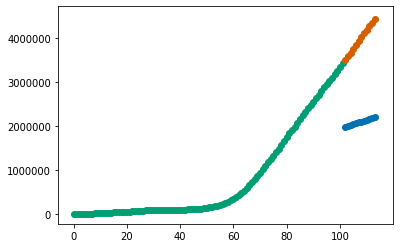

In [23]:
# plot predictions and actual values
plt.scatter(X_test_confirmed, y_pred)
plt.scatter(X_train_confirmed, y_train_confirmed)
plt.scatter(X_test_confirmed, y_test_confirmed)

In [24]:
# define a model for a linear regression
alpha = linear_model.Ridge(alpha=0.01)

# build the model, show r2 and coeffs, and return the predictions
y_pred = regression(X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed, alpha)

r2: -23.28 

Coefficients: 
 [[30658.65919801]]


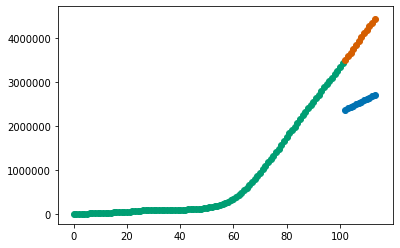

In [25]:
plt.scatter(X_test_confirmed, y_pred)
plt.scatter(X_train_confirmed, y_train_confirmed)
plt.scatter(X_test_confirmed, y_test_confirmed)